In [7]:
import numpy as np
import pandas as pd
from numba import njit
from pandas.api.types import is_datetime64_any_dtype
import time

@njit
def CBS(row):
    """consolidated bid size"""
    col = row.copy() * -1
    col[col <= 0] = 0
    diff = np.abs(np.diff(col))
    return np.sum(diff) + col[0]
@njit
def CAS(row):
    """consolidated ask size"""
    col = row.copy()
    col[col <= 0] = 0
    diff = np.abs(np.diff(col))
    return np.sum(diff) + col[0]
@njit
def TCBS(cbs):
    """total consolidated bid size"""
    return np.sum(cbs)
@njit
def TCAS(cas):
    """total consolidated ask size"""
    return np.sum(cas)
@njit
def WBP(cbs):
    """weighted bid price"""
    tcbs = TCBS(cbs)
    wbp = 0
    for p, cbsi in enumerate(cbs):
        wbp += (p+1) * (cbsi / tcbs)
    return wbp
@njit
def WAP(cas):
    """weighted bid price"""
    tcas = TCAS(cas)
    wbp = 0
    for p, casi in enumerate(cas):
        wbp += (p+1) * (casi / tcas)
    return wbp
@njit
def AWS(row):
    """actvity weighted spread"""
    return WAP(row) - WBP(row)

def AP(tapes_segment):
    """average price"""
    pass

def AWR(tapes):
    """activity weighted return"""
    pass

@njit
def calculate_high_bid(sliced_arr):
    negative_indices = np.where(sliced_arr < 0, np.arange(sliced_arr.shape[1]), -1)
    max_negative_index = []
    for row in negative_indices:
        max_negative_index.append(max(row))
    max_negative_index.sort()
    high_bid = max_negative_index[len(max_negative_index) // 2] + 1 # get median
    return high_bid

@njit
def calculate_low_ask(sliced_arr):
    positive_indices = np.where(sliced_arr > 0, np.arange(sliced_arr.shape[1]), 800)
    min_positive_index = []
    for row in positive_indices:
        min_positive_index.append(min(row))
    min_positive_index.sort()
    low_ask =  min_positive_index[len(min_positive_index) // 2] + 1 # get median
    return low_ask

def features(day_df, seg_length = "1m", vis=False):

    s = time.time()
    if not is_datetime64_any_dtype(day_df.index):
        print("converting index to datetime")
        day_df.index = pd.to_datetime(day_df.index)
        print(time.time() - s, "taken to convert index")

    segment_length_options = {"1s": int(60*60*8.5), 
                              "5s": int(12*60*8.5), 
                              "10s": int(6*60*8.5),
                              "15s": int(4*60*8.5), 
                              "20s": int(3*60*8.5),
                              "30s": int(2*60*8.5),
                              "1m": int(60*8.5),
                              "2m": int(30*8.5),
                              "5m": int(12*8.5),
                              "10m": int(6*8.5), 
                              "30m": int(2*8.5)}
    
    if seg_length not in segment_length_options.keys():
        raise ValueError("Invalid segment length / step\nPlease pick from "+str(segment_length_options.keys()))
    
    rows = []
    arr = day_df.to_numpy()
    min_time = day_df.index[0]
    max_time = day_df.index[-1]
    start_time = min_time
    length_df = len(day_df)

    cbs_arr = np.zeros((segment_length_options[seg_length],800))
    cas_arr = np.zeros((segment_length_options[seg_length],800))

    i = 0
    start_index = 0
    while start_time < max_time:
        
        end_time = start_time + pd.Timedelta(seg_length)

        end_index = start_index

        while day_df.index[end_index] < end_time and end_index < length_df - 1:
            end_index += 1

        if vis:
            print(start_index, end_index)

        sliced_arr = arr[start_index:end_index]

        row = {"end_time": end_time}

        cbs_arr[i] = np.apply_along_axis(CBS, axis=0, arr = sliced_arr)
        cas_arr[i] = np.apply_along_axis(CAS, axis=0, arr = sliced_arr)
        row["TCBS"] = TCBS(cbs_arr[i])
        row["TCAS"] = TCAS(cas_arr[i])
        row["WBP"] = WBP(cbs_arr[i])
        row["WAP"] = WAP(cas_arr[i])
        row["AWS"] = row["WAP"] - row["WBP"]

        row["high_bid"] = calculate_high_bid(sliced_arr)
        row["low_ask"] = calculate_low_ask(sliced_arr)
        if row["high_bid"] > row["low_ask"]:
            print("bid/ask error,", end_time)

        row["mid_price"] = (row["high_bid"] + row["low_ask"]) / 2
        row["spread"] = row["low_ask"] - row["high_bid"]

        rows.append(row)

        i += 1

        start_time = end_time
        start_index = end_index

        

    out_df = pd.DataFrame(rows)
    out_df.index = out_df["end_time"]
    out_df["WMP"] = (out_df["WBP"] + out_df["WAP"]) / 2
    out_df["TCBS-TCAS"] = out_df["TCBS"] - out_df["TCAS"]
    out_df["TCBS+TCAS"] = out_df["TCBS"] + out_df["TCAS"]

    print(time.time() - s, "time taken to run")

    return out_df.drop(columns=["end_time"], axis = 1), cbs_arr, cas_arr

In [8]:
from tools import read_csr, get_Tapes
lob_data = read_csr(0)[0]
tapes_data = get_Tapes(0)[0]

Opening UoB_Set01_2025-01-02tapes.csv


In [14]:
min_df, cbs_arr, cas_arr = features(lob_data, seg_length="5s")
min_df

32.90600609779358 time taken to run


TCBS   TCAS         WBP  ...         WMP  TCBS-TCAS  TCBS+TCAS
end_time                                       ...                                  
2024-03-12 08:00:05   43.0   80.0  189.697674  ...  271.798837      -37.0      123.0
2024-03-12 08:00:10   70.0  161.0  245.600000  ...  264.809317      -91.0      231.0
2024-03-12 08:00:15  165.0  176.0  138.890909  ...  234.272159      -11.0      341.0
2024-03-12 08:00:20  229.0  171.0  187.349345  ...  294.142509       58.0      400.0
2024-03-12 08:00:25  551.0  259.0  224.003630  ...  333.785599      292.0      810.0
...                    ...    ...         ...  ...         ...        ...        ...
2024-03-12 16:29:40  536.0  196.0  206.194030  ...  351.655688      340.0      732.0
2024-03-12 16:29:45  274.0  114.0  219.255474  ...  345.772474      160.0      388.0
2024-03-12 16:29:50  332.0  183.0  235.162651  ...  356.114112      149.0      515.0
2024-03-12 16:29:55  193.0  224.0  201.321244  ...  314.763300      -31.0      417.0
2024-03-12 16:30:00  169.0  184.0  208.301775  ...  341.474257      -15.0      353.0

[6120 rows x 12 columns]

<Axes: xlabel='end_time'>

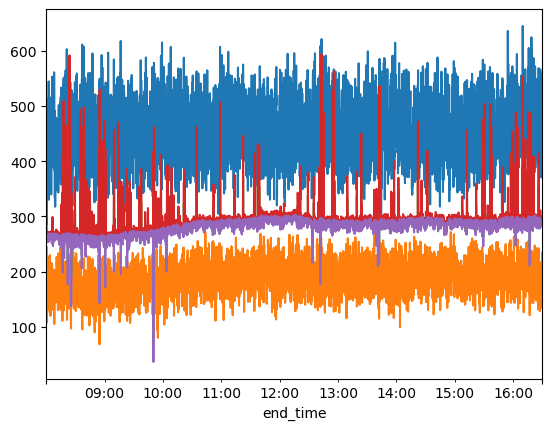

In [15]:
import matplotlib.pyplot as plt

min_df["WAP"].plot()
min_df["WBP"].plot()
min_df["mid_price"].plot()
min_df["low_ask"].plot()
min_df["high_bid"].plot()

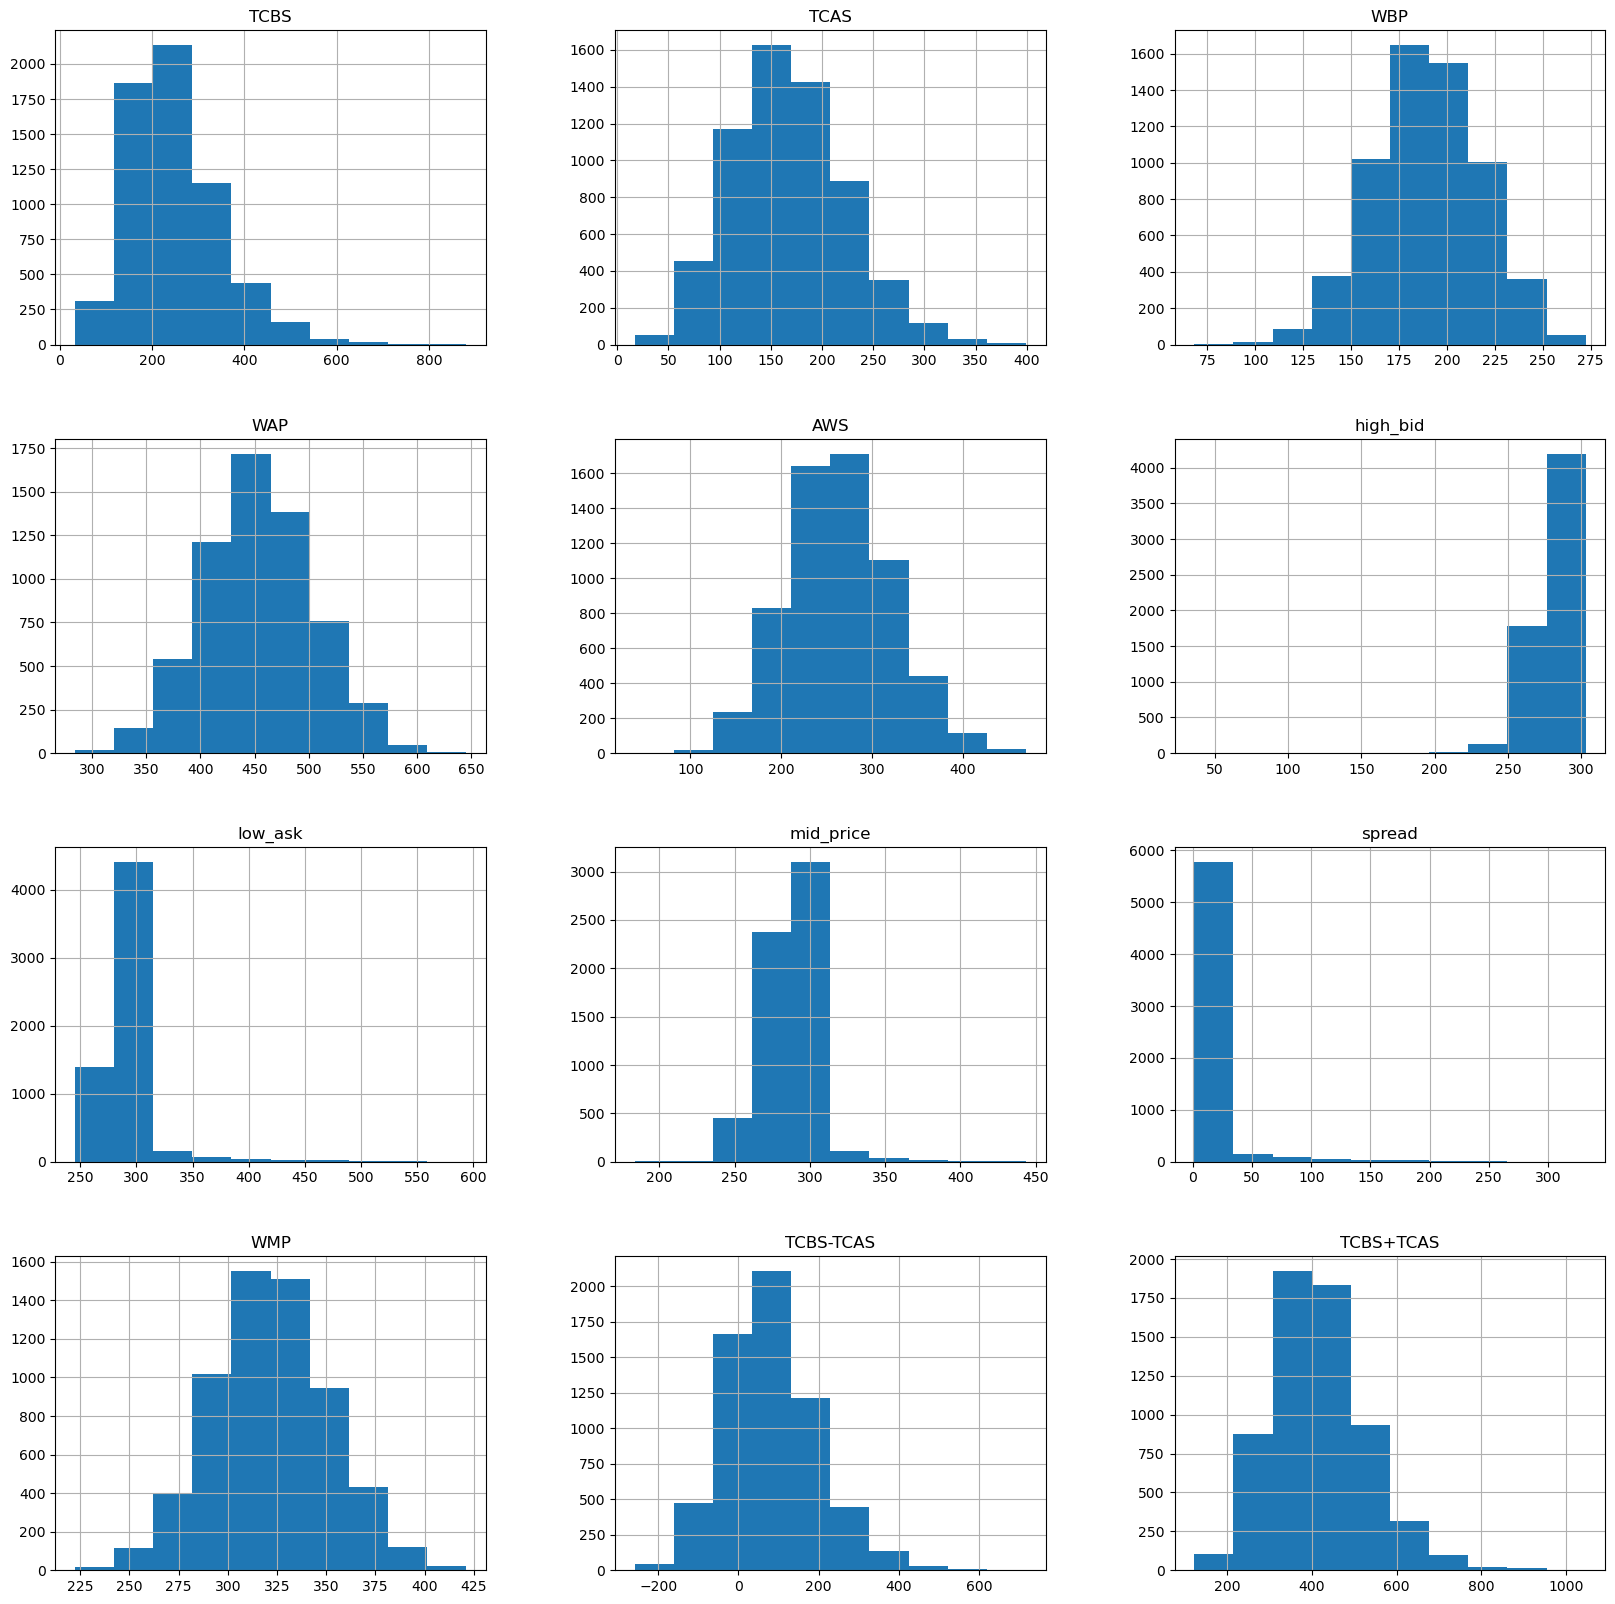

In [16]:
min_df.hist(figsize=(20,20))
plt.show()

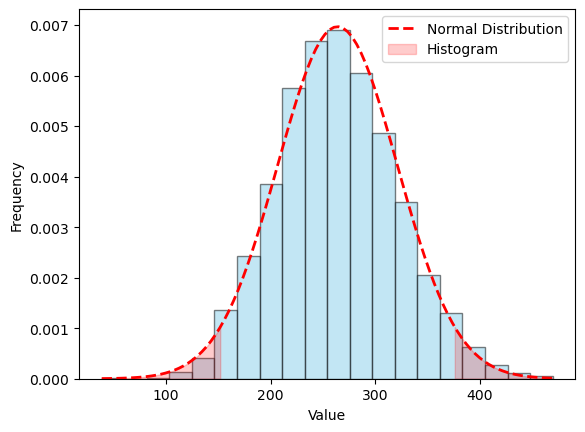

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Assuming you have imported min_df and plt.hist(min_df["AWS"], bins=20) elsewhere

# Plot the histogram
plt.hist(min_df["AWS"], bins=20, density=True, alpha=0.5, color='skyblue', edgecolor='black')

# Calculate mean and standard deviation of the data
mean = min_df["AWS"].mean()
std_dev = min_df["AWS"].std()

# Generate data points for the normal distribution curve
x = np.linspace(min_df["AWS"].min(), min_df["AWS"].max(), 100)
y = norm.pdf(x, mean, std_dev)

# Plot the normal distribution curve
plt.plot(x, y, color='red', linestyle='--', linewidth=2)

# Calculate critical values for the lower and upper tails
lower_critical_value = norm.ppf(0.025, mean, std_dev)
upper_critical_value = norm.ppf(0.975, mean, std_dev)

# Shade the area representing values with a 5% probability on both tails
x_shade_lower = np.linspace(min_df["AWS"].min(), lower_critical_value, 100)
x_shade_upper = np.linspace(upper_critical_value, min_df["AWS"].max(), 100)
plt.fill_between(x_shade_lower, norm.pdf(x_shade_lower, mean, std_dev), color='red', alpha=0.2)
plt.fill_between(x_shade_upper, norm.pdf(x_shade_upper, mean, std_dev), color='red', alpha=0.2)

# Add legend and labels
plt.legend(['Normal Distribution', 'Histogram'])
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


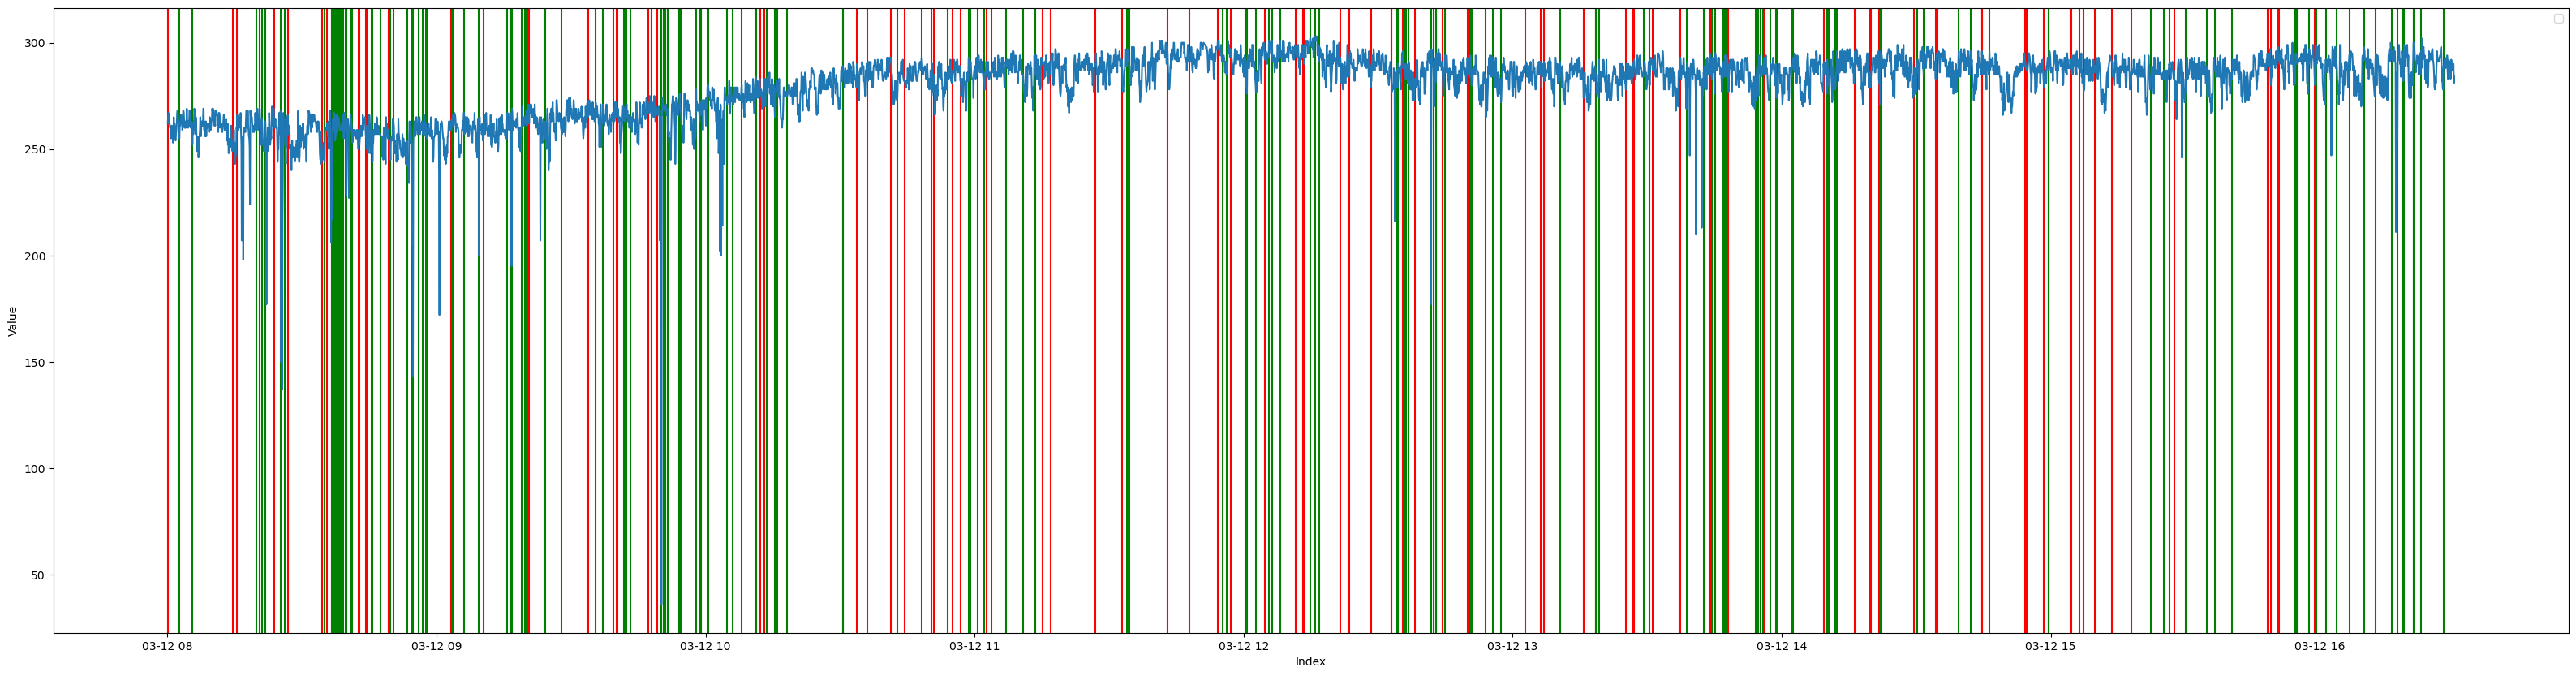

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Assuming you have imported min_df elsewhere

# Calculate mean and standard deviation of the data
mean = min_df["AWS"].mean()
std_dev = min_df["AWS"].std()

# Calculate critical values for the lower and upper tails
lower_critical_value = norm.ppf(0.025, mean, std_dev)
upper_critical_value = norm.ppf(0.975, mean, std_dev)

# Find the points within the tails
points_in_lower_tail = min_df["AWS"][min_df["AWS"] < lower_critical_value]
points_in_upper_tail = min_df["AWS"][min_df["AWS"] > upper_critical_value]

plt.figure(figsize=(40,10))
# Plot the line plot of min_df["AWS"]
for p in points_in_lower_tail.index:
    plt.axvline(p, color="red")

for p in points_in_upper_tail.index:
    plt.axvline(p, color="green")

    
#plt.plot(min_df["AWS"], color='black', label='AWS')
#plt.plot(min_df["WAP"], color='red', label='WAP')
#plt.plot(min_df["WBP"], color='blue', label='WBP')
#plt.plot(min_df["WMP"], color='purple', label='WBP')
#plt.plot(min_df["mid_price"])
#plt.plot(min_df["low_ask"])
plt.plot(min_df["high_bid"])

# Highlight points in the lower tail
#plt.scatter(points_in_lower_tail.index, points_in_lower_tail, color='red', label='Lower Tail')

# Highlight points in the upper tail
#plt.scatter(points_in_upper_tail.index, points_in_upper_tail, color='green', label='Upper Tail')



# Add legend and labels
plt.legend()
plt.xlabel('Index')
plt.ylabel('Value')

# Show the plot
plt.show()


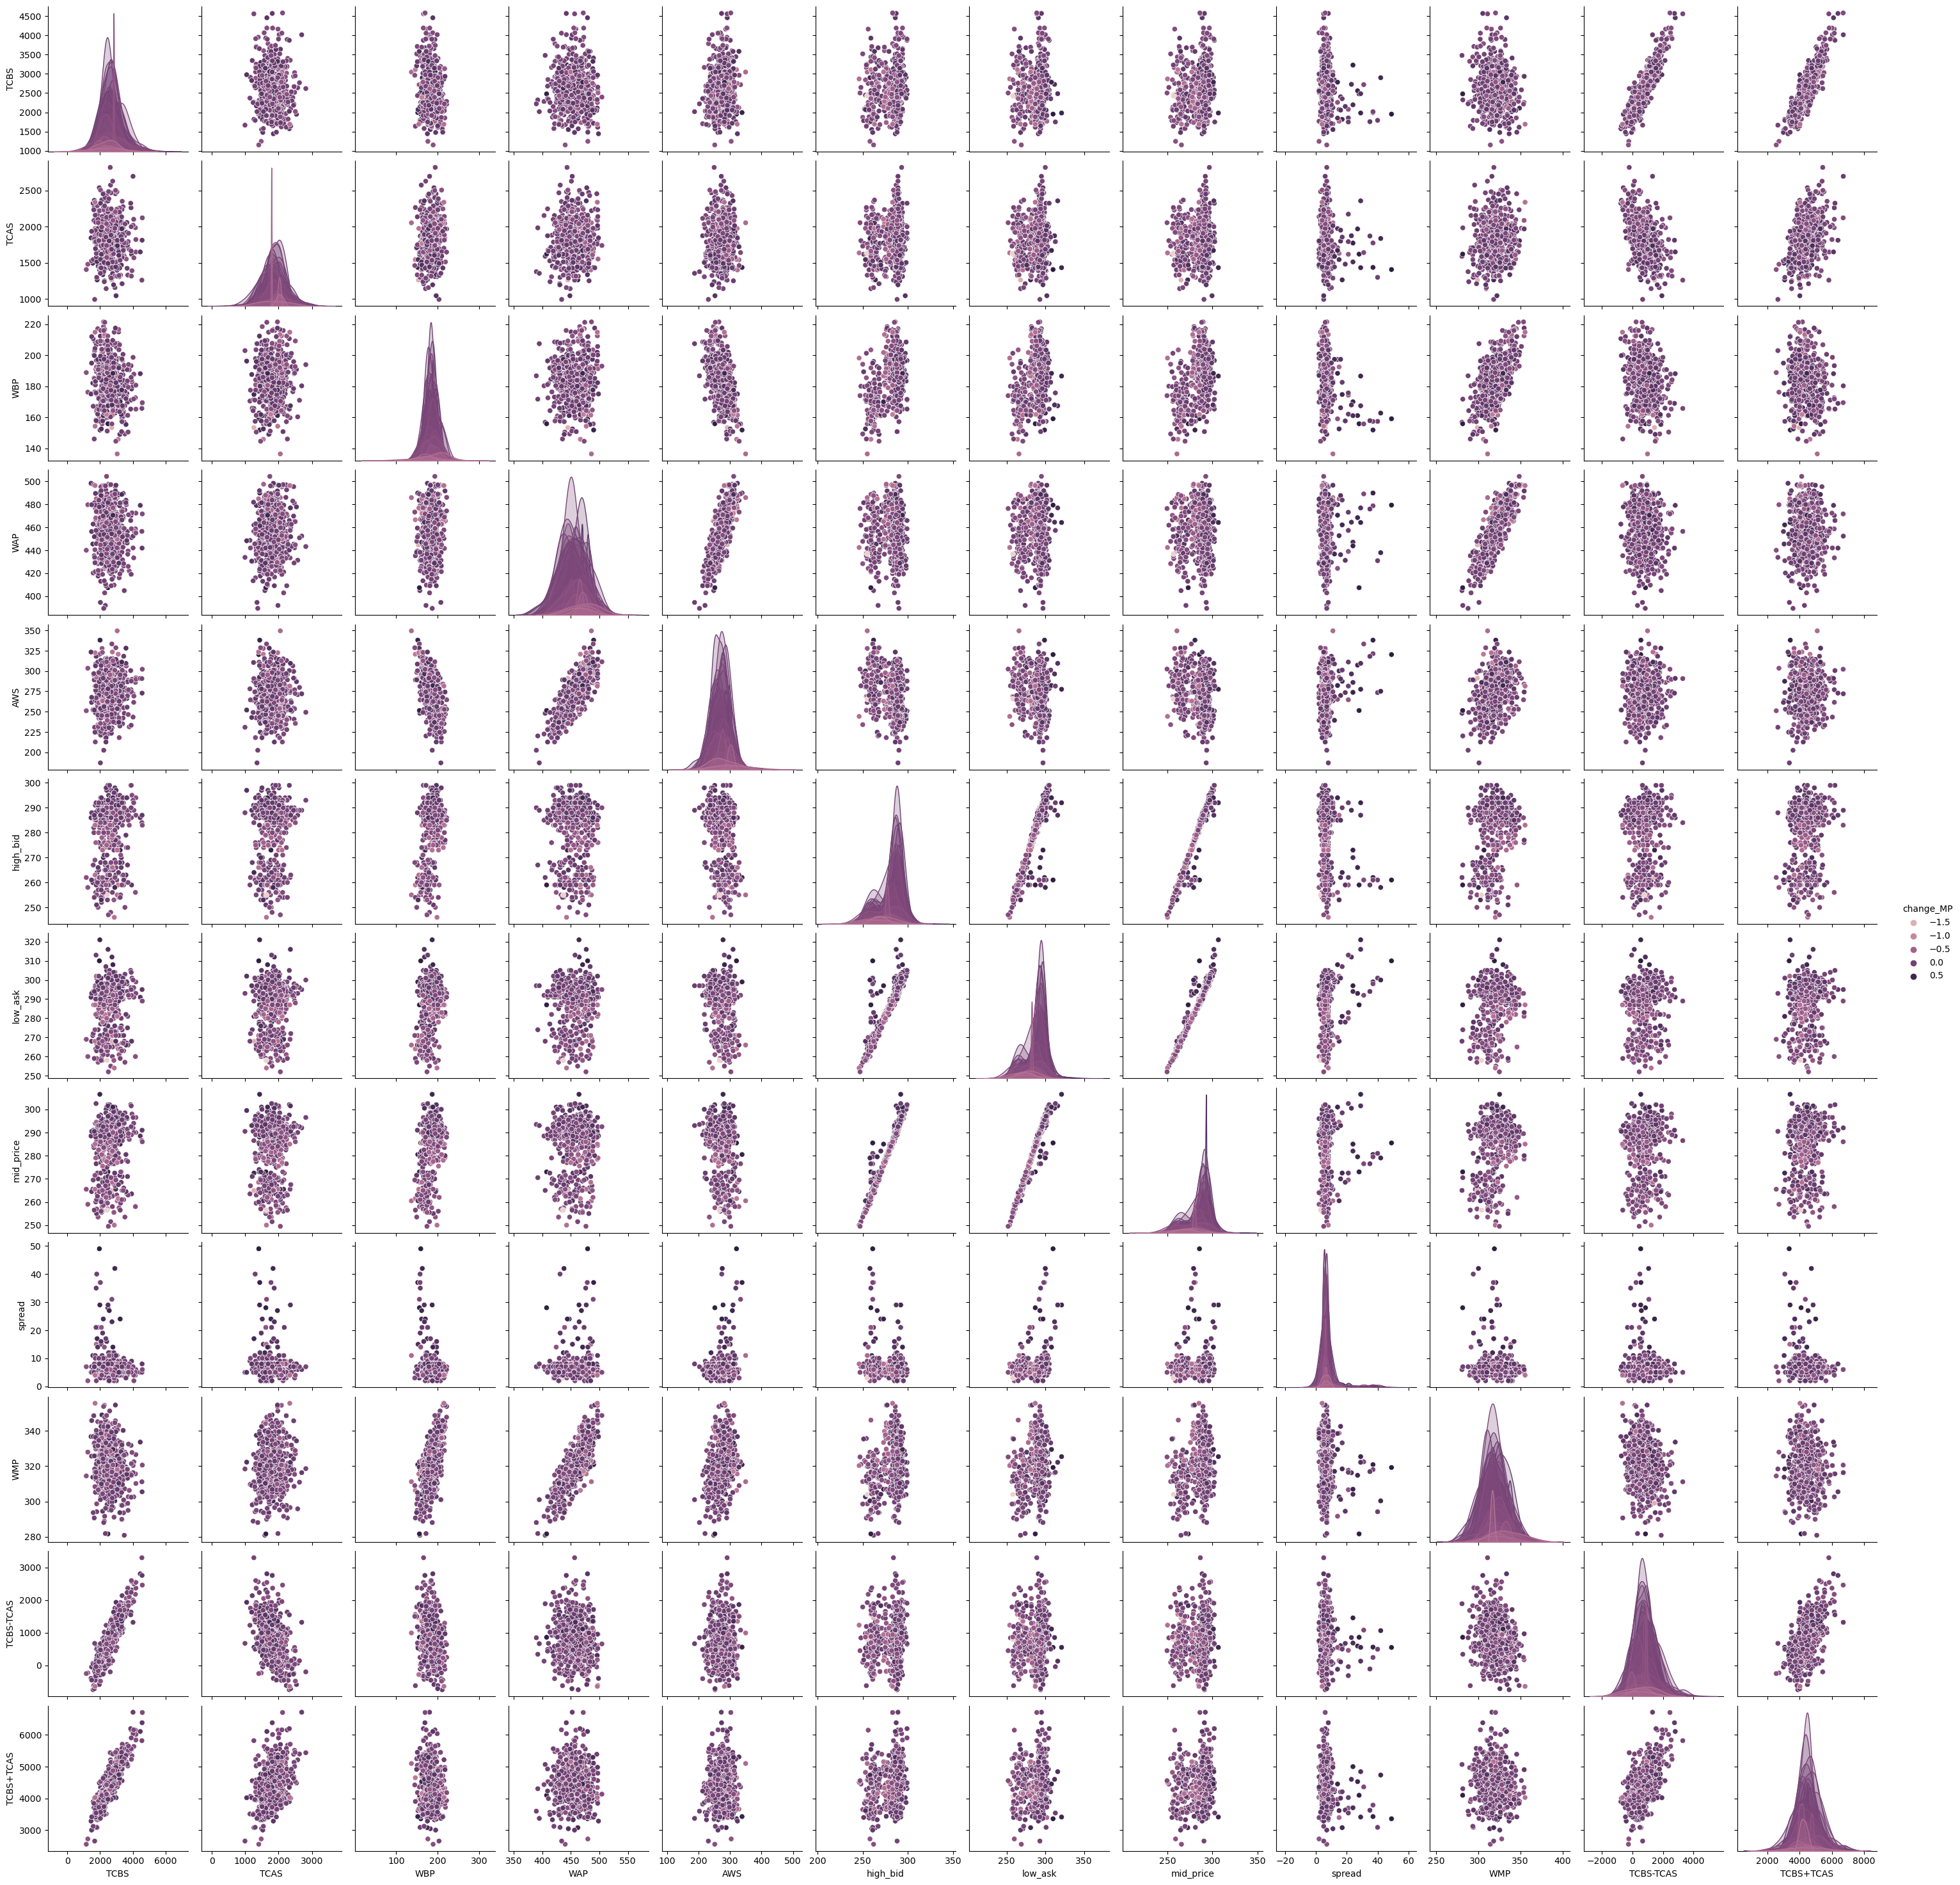

In [9]:
import seaborn as sns

min_df["change_MP"] = np.log(min_df["mid_price"].diff(1) + 26.5) - np.log(26.5)

sns.pairplot(min_df, hue = "change_MP")

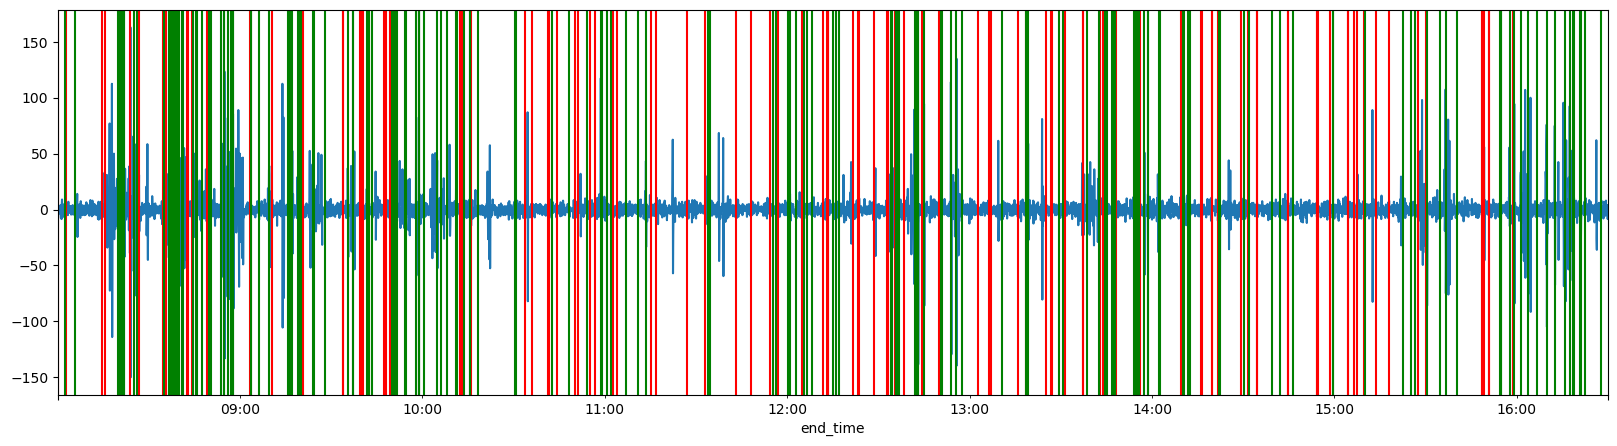

In [22]:
min_df["change_MP"] = min_df["mid_price"].diff(1)
min_df["change_MP"].plot(figsize=(20,5))

#plt.twinx()
#min_df["mid_price"].plot(color="black")

for p in points_in_lower_tail.index:
    plt.axvline(p, color="red")

for p in points_in_upper_tail.index:
    plt.axvline(p, color="green")

<Axes: >

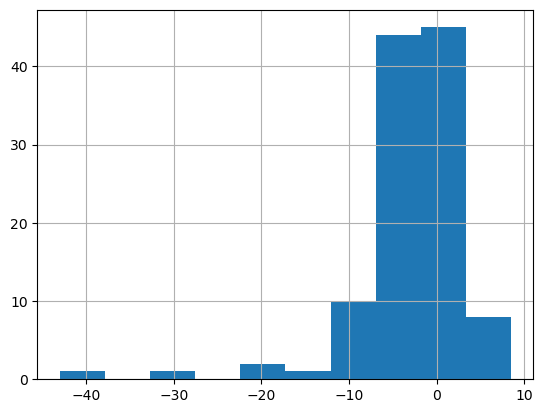

In [23]:
min_df["change_MP"][points_in_lower_tail.index].hist()

<Axes: >

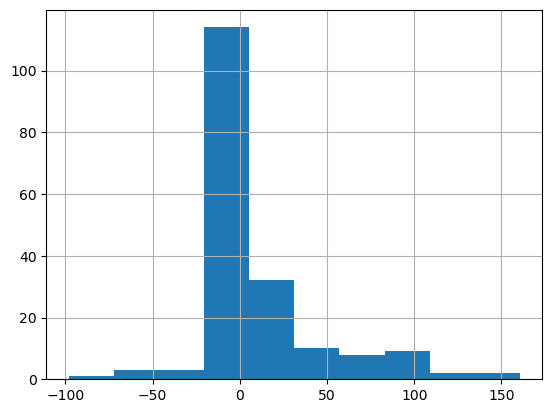

In [24]:
min_df["change_MP"][points_in_upper_tail.index].hist()